## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras


Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.5,0.8]
redice_lr_patient = [5,20]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 1s 26us/step - loss: 1.2325 - acc: 0.5748 - val_loss: 1.4762 - val_acc: 0.4797
Epoch 14/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.2060 - acc: 0.5848 - val_loss: 1.4815 - val_acc: 0.4767
Epoch 15/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.1826 - acc: 0.5936 - val_loss: 1.4736 - val_acc: 0.4815
Epoch 16/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.1606 - acc: 0.6004 - val_loss: 1.4661 - val_acc: 0.4868
Epoch 17/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.1364 - acc: 0.6103 - val_loss: 1.4695 - val_acc: 0.4848
Epoch 18/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.1145 - acc: 0.6194 - val_loss: 1.4585 - val_acc: 0.4910
Epoch 19/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.0919 - acc: 0.6267 - val_loss: 1.4596 - val_acc: 0.4861
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 2s 43us/step - loss: 2.2130 - acc: 0.2680 - val_loss: 2.1829 - val_acc: 0.3155
Epoch 2/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.7516 - acc: 0.3885 - val_loss: 1.8606 - val_acc: 0.3709
Epoch 3/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.6250 - acc: 0.4299 - val_loss: 1.7009 - val_acc: 0.4045
Epoch 4/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.5522 - acc: 0.4572 - val_loss: 1.6430 - val_acc: 0.4274
Epoch 5/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.4939 - acc: 0.4797 - val_loss: 1.6078 - val_acc: 0.4329
Epoch 6/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.4482 - acc: 0.4958 - val_loss: 1.5789 - val_acc: 0.4450
Epoch 7/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.4077 - acc: 0.5110 - val_loss: 1.5589 - val_acc: 0.4494
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 1s 25us/step - loss: 0.9709 - acc: 0.6730 - val_loss: 1.4724 - val_acc: 0.4944
Epoch 25/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.9498 - acc: 0.6815 - val_loss: 1.4764 - val_acc: 0.4964
Numbers of exp: 5, reduce_factor: 0.80, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

50000/50000 [==============================] - 1s 29us/step - loss: 0.9130 - acc: 0.6846 - val_loss: 1.4008 - val_acc: 0.5077
Epoch 12/25
50000/50000 [==============================] - 1s 30us/step - loss: 0.8848 - acc: 0.6966 - val_loss: 1.3601 - val_acc: 0.5182
Epoch 13/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.8525 - acc: 0.7100 - val_loss: 1.4171 - val_acc: 0.4986
Epoch 14/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.8220 - acc: 0.7205 - val_loss: 1.4495 - val_acc: 0.4963
Epoch 15/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.7946 - acc: 0.7309 - val_loss: 1.4539 - val_acc: 0.5038
Epoch 16/25
50000/50000 [==============================] - 1s 29us/step - loss: 0.7612 - acc: 0.7446 - val_loss: 1.4706 - val_acc: 0.4999
Epoch 17/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.7340 - acc: 0.7542 - val_loss: 1.5553 - val_acc: 0.4824

Epoch 00017: ReduceLROnPlateau reducing learn

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.9779 - acc: 0.3310 - val_loss: 1.9472 - val_acc: 0.3415
Epoch 2/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.6117 - acc: 0.4381 - val_loss: 1.7103 - val_acc: 0.4008
Epoch 3/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.5103 - acc: 0.4724 - val_loss: 1.6379 - val_acc: 0.4225
Epoch 4/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.4481 - acc: 0.4961 - val_loss: 1.6076 - val_acc: 0.4315
Epoch 5/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.3981 - acc: 0.5137 - val_loss: 1.5760 - val_acc: 0.4429
Epoch 6/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.3586 - acc: 0.5287 - val_loss: 1.5424 - val_acc: 0.4580
Epoch 7/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.3230 - acc: 0.5430 - val_loss: 1.5404 - val_acc

50000/50000 [==============================] - 1s 28us/step - loss: 0.9891 - acc: 0.6718 - val_loss: 1.4376 - val_acc: 0.4955
Epoch 25/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.9746 - acc: 0.6776 - val_loss: 1.4347 - val_acc: 0.5017
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.1789 - acc: 0.5972 - val_loss: 1.4614 - val_acc: 0.4834
Epoch 13/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.1575 - acc: 0.6063 - val_loss: 1.4677 - val_acc: 0.4828
Epoch 14/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.1383 - acc: 0.6129 - val_loss: 1.4562 - val_acc: 0.4875
Epoch 15/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.1195 - acc: 0.6220 - val_loss: 1.4515 - val_acc: 0.4882
Epoch 16/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.1013 - acc: 0.6296 - val_loss: 1.4578 - val_acc: 0.4851
Epoch 17/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.0843 - acc: 0.6352 - val_loss: 1.4555 - val_acc: 0.4954
Epoch 18/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.0654 - acc: 0.6434 - val_loss: 1.4481 - val_acc: 0.4943
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.9406 - acc: 0.3411 - val_loss: 2.0074 - val_acc: 0.3436
Epoch 2/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.6466 - acc: 0.4276 - val_loss: 1.8629 - val_acc: 0.3656
Epoch 3/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.5277 - acc: 0.4683 - val_loss: 1.7311 - val_acc: 0.3936
Epoch 4/25
50000/50000 [==============================] - 1s 25us/step - loss: 1.4496 - acc: 0.4951 - val_loss: 1.8102 - val_acc: 0.3831
Epoch 5/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.3899 - acc: 0.5145 - val_loss: 1.6312 - val_acc: 0.4281
Epoch 6/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.3334 - acc: 0.5351 - val_loss: 1.6407 - val_acc: 0.4283
Epoch 7/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.2873 - acc: 0.5527 - val_loss: 1.5760 - val_acc

50000/50000 [==============================] - 1s 29us/step - loss: 0.8220 - acc: 0.7351 - val_loss: 1.4788 - val_acc: 0.4941

Epoch 00023: ReduceLROnPlateau reducing learning rate to 2.2500000341096893e-05.
Epoch 24/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.7892 - acc: 0.7520 - val_loss: 1.4376 - val_acc: 0.5058
Epoch 25/25
50000/50000 [==============================] - 1s 27us/step - loss: 0.7785 - acc: 0.7570 - val_loss: 1.4315 - val_acc: 0.5064
Numbers of exp: 15, reduce_factor: 0.50, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048 

50000/50000 [==============================] - 2s 32us/step - loss: 1.4361 - acc: 0.5021 - val_loss: 1.6066 - val_acc: 0.4392
Epoch 11/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4104 - acc: 0.5114 - val_loss: 1.5906 - val_acc: 0.4385
Epoch 12/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.3865 - acc: 0.5210 - val_loss: 1.5923 - val_acc: 0.4429
Epoch 13/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.3636 - acc: 0.5283 - val_loss: 1.5704 - val_acc: 0.4473
Epoch 14/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3411 - acc: 0.5370 - val_loss: 1.5569 - val_acc: 0.4522
Epoch 15/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.3219 - acc: 0.5445 - val_loss: 1.5656 - val_acc: 0.4523
Epoch 16/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.3024 - acc: 0.5519 - val_loss: 1.5500 - val_acc: 0.4594
Epoch 17/25
50000/50000 [=====================

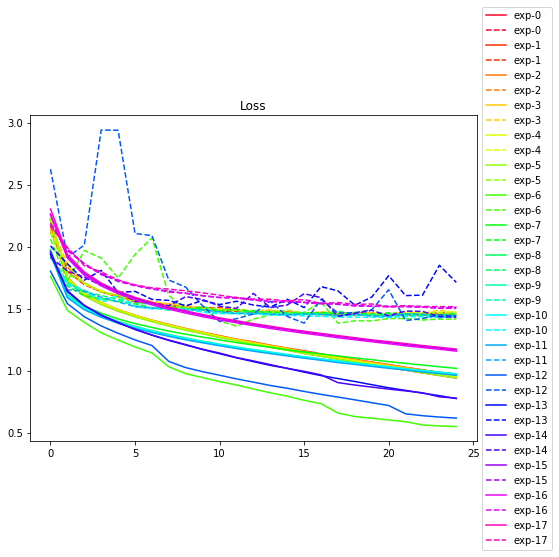

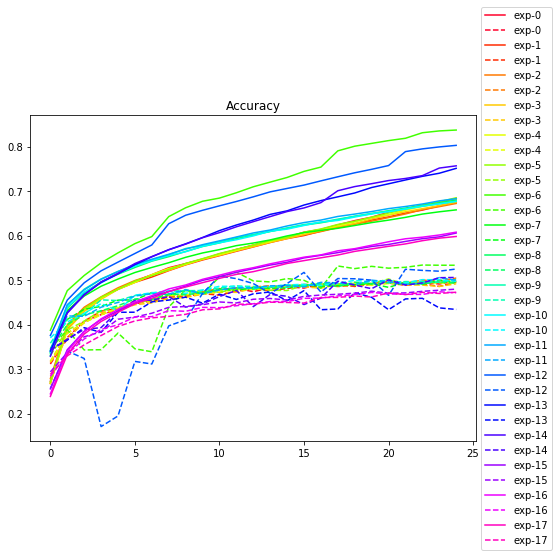

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i,Optimizer:%s, reduce_factor: %.2f, reduce_patient: %i" % (i,optim, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0,Optimizer:<keras.optimizers.SGD object at 0x7f7e230c7a90>, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_55 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_56 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________________________

KeyboardInterrupt: 